In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import time
%matplotlib inline
color = sns.color_palette()

## Explore the data set

In [144]:
df = ( pd.read_json("train.json")
         .reset_index(drop=True) )
df.shape

(49352, 15)

In [145]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [146]:
df.dtypes

bathrooms          float64
bedrooms             int64
building_id         object
created             object
description         object
display_address     object
features            object
interest_level      object
latitude           float64
listing_id           int64
longitude          float64
manager_id          object
photos              object
price                int64
street_address      object
dtype: object

In [147]:
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


### What is the target variable to predict?

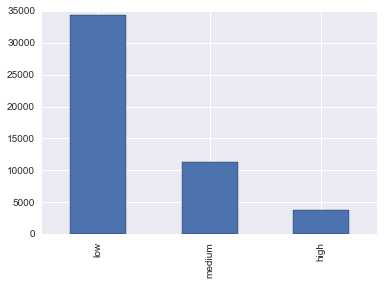

In [148]:
# Variable to predict
df['interest_level'].value_counts().plot(kind='bar', color=color[0])

#### How does it vary with some of the categorical features?

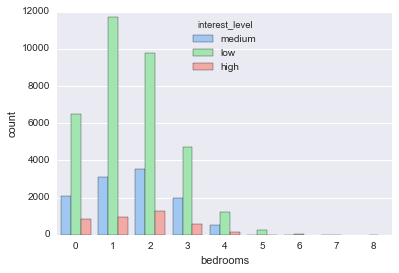

In [149]:
sns.countplot(x='bedrooms', hue='interest_level', data=df, palette='pastel')

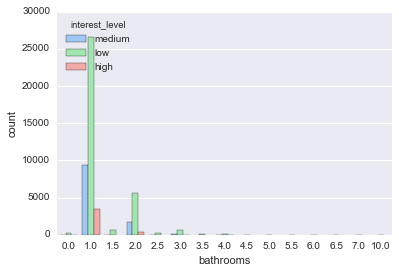

In [150]:
sns.countplot(x='bathrooms', hue='interest_level', data=df, palette='pastel')

### What is the range of the 'price' numeric variable?

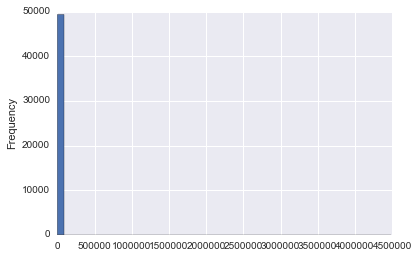

In [151]:
df.price.plot.hist(bins=50)

The histogram does not help us understand the range of the values. Let's try to plot a scatter plot.

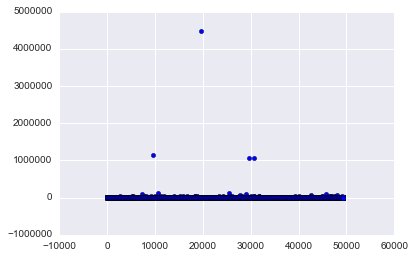

In [152]:
plt.scatter(df.index, df.price)

It is now clear that there are some outliers in this data set. We could cap the top 1% of the dataset by price.

C:\WinPython-64bit-3.5.1.3\python-3.5.1.amd64\Lib\site-packages\pandas\core\indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


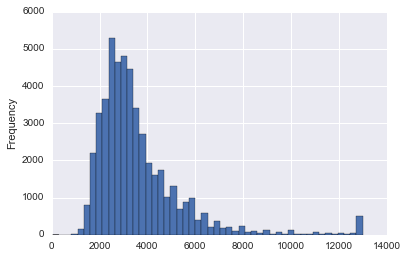

In [153]:
outlier_limit = df.price.quantile(0.99)

# Set this limit as the price for all outliers
df.price.loc[df['price'] > outlier_limit] = outlier_limit
df.price.plot.hist(bins=50)

Now, the histogram gives us a better idea of the price range of the bulk of the listings.

### What does the building id data tell us?

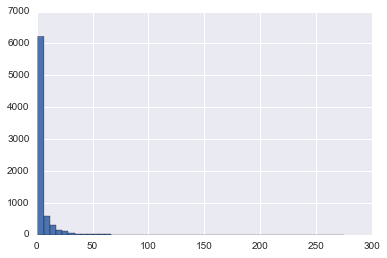

In [154]:
bldg_id_counts = df.building_id.value_counts()
plt.hist(bldg_id_counts[bldg_id_counts < 500], bins=50)
plt.show()

df['listings_in_bldg'] = df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

### Visualize the time of creation of the listings

In [155]:
df['created'] = pd.to_datetime(df['created'])

df['created_month'] = df.created.map(lambda dt: dt.month)
df['created_day'] = df.created.map(lambda dt: dt.dayofweek)

In [156]:
df.created_day.value_counts()

2    9414
1    8417
3    8195
4    7593
5    6953
6    4541
0    4239
Name: created_day, dtype: int64

In [157]:
df.created_month.value_counts()

6    17144
4    16411
5    15797
Name: created_month, dtype: int64

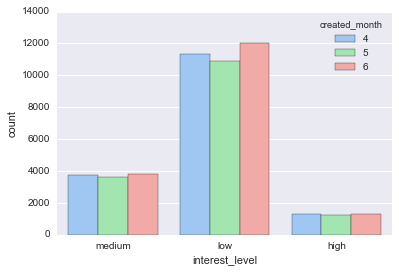

In [252]:
sns.countplot(x='interest_level', hue='created_month', data=df, palette='pastel')

There does not seem to any trend of interest level with repect to the month of creation.

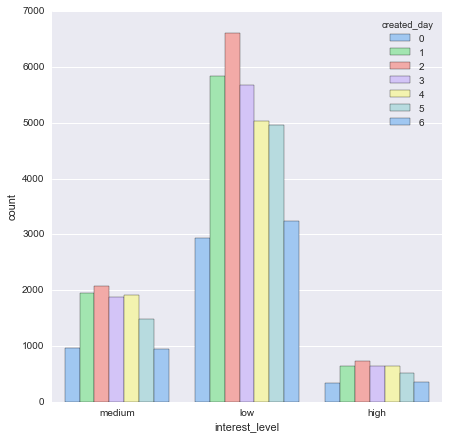

In [253]:
plt.figure(figsize=(7,7)) 
sns.countplot(x='interest_level', hue='created_day', data=df, palette='pastel')

It is clear that there are fewer listings made on Mondays and Sundays. Also in general, it seems like most listings are posted on Wednesdays.

### Visualize the listings by location

(49216, 19)


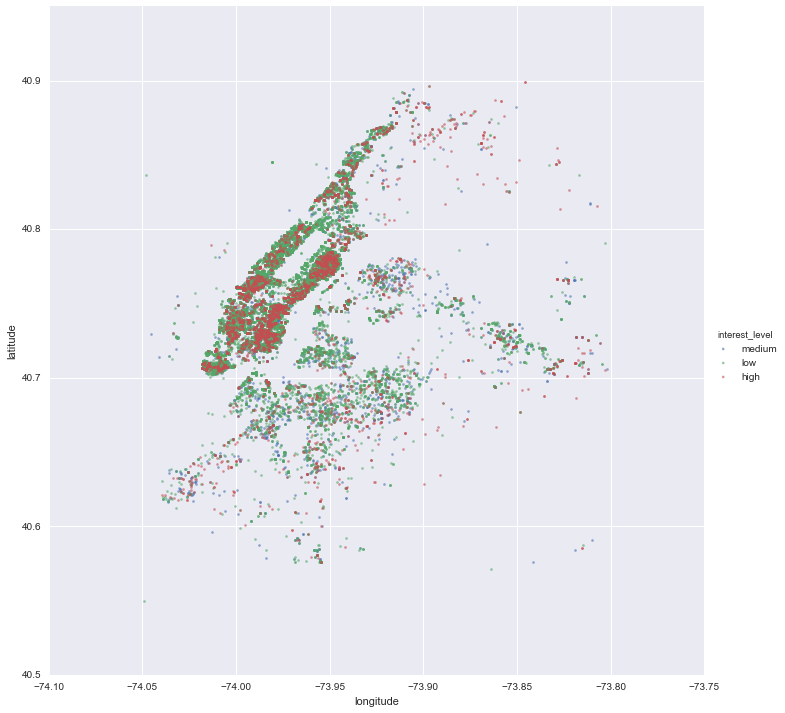

In [161]:
# Remove outlier points w.r.t latitude and longitude
outlier_mask = ( (df.latitude < 40.5) | (df.latitude > 40.9) | 
                 (df.longitude < -74.05) | (df.longitude > -73.80) )
df_cropped = df.drop(df.index[outlier_mask], axis=0)
print(df_cropped.shape)

# Map the points and color them by interest level
sns.lmplot(x='longitude', y='latitude', data=df_cropped, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10)

Some interesting things to note from the map above:
- Manhattan is clearly visible from the map. Most listings are here.
- Central Park is also clear on the map as the rectangular area in Manhattan with almost(!) no listings.
- The east side of the park seems to have more listings and also possibly more listings of high interest.

How can we use this location information?

### How can we use the features and description data?

In [260]:
from sklearn.feature_extraction.text import CountVectorizer
desc_count_vec = CountVectorizer(stop_words='english', max_features=200)
desc = desc_count_vec.fit_transform(df.description)
cols = desc_count_vec.get_feature_names()
desc_count_vec_df = pd.DataFrame(desc.todense(), columns=cols)
desc_count_vec_df.drop(['br'], axis=1, inplace=True)
desc_count_vec_df.head(3)

,24,_blank,access,amazing,amenities,amp,apartment,apartments,appliances,appointment,...,village,walk,washer,water,website_redacted,west,white,windows,wood,york
0,0,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,1,1,0,0,0,1


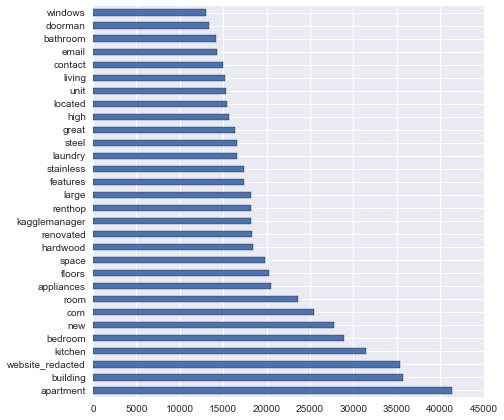

In [261]:
desc_counts = desc_count_vec_df.sum()
freq_words = desc_counts.nlargest(30)
freq_words.plot(kind='barh', figsize=(7,7))

### Clean the features list

In [166]:
df.features.head()

0                                                   []
1    [Doorman, Elevator, Fitness Center, Cats Allow...
2    [Laundry In Building, Dishwasher, Hardwood Flo...
3                            [Hardwood Floors, No Fee]
4                                            [Pre-War]
Name: features, dtype: object

In [175]:
def clean(features):
    if len(features) == 0:
        return features
    return [f.lower().replace(' ', '').replace('-','') for f in features]

In [176]:
df['cleaned_features'] = df.features.apply(lambda flist: clean(flist))
df['cleaned_features'].head()

0                                                   []
1    [doorman, elevator, fitnesscenter, catsallowed...
2    [laundryinbuilding, dishwasher, hardwoodfloors...
3                              [hardwoodfloors, nofee]
4                                             [prewar]
Name: cleaned_features, dtype: object

In [183]:
from sklearn.feature_extraction.text import CountVectorizer
df['combined_features'] = df.cleaned_features.apply(lambda l: ', '.join(l))
feature_count_vec = CountVectorizer(stop_words='english', max_features=200)
features = feature_count_vec.fit_transform(df.combined_features)
cols = feature_count_vec.get_feature_names()
feature_count_vec_df = pd.DataFrame(features.todense(), columns=cols)
feature_count_vec_df.head()

,24,24hrdoorman,2blkstobedfordlstop,7concierge,7doorman,actualapt,airconditioning,allmodern,allutilitiesincluded,assignedparkingspace,...,virtualdoorman,walkincloset,wallsofwindows,washer,washerinunit,wheelchairaccess,wheelchairramp,wifiaccess,woodburningfireplace,work
49347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


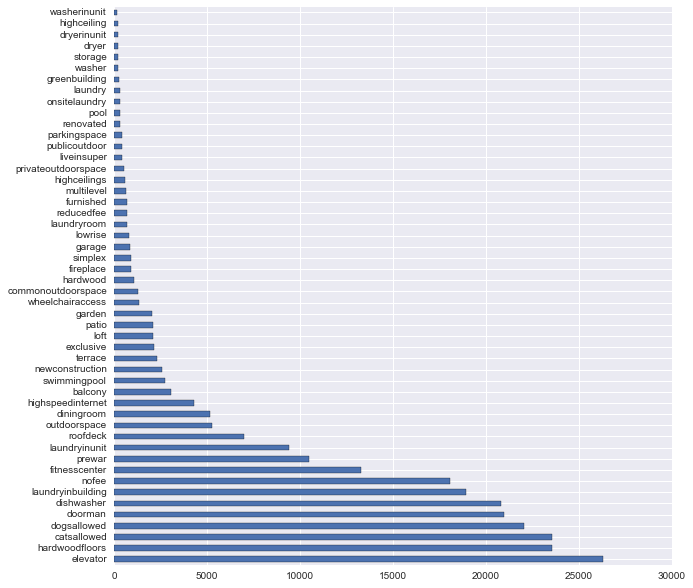

In [201]:
feature_counts = feature_count_vec_df.sum()
freq_feature_words = feature_counts.nlargest(50)
freq_feature_words.plot(kind='barh', figsize=(10,10))

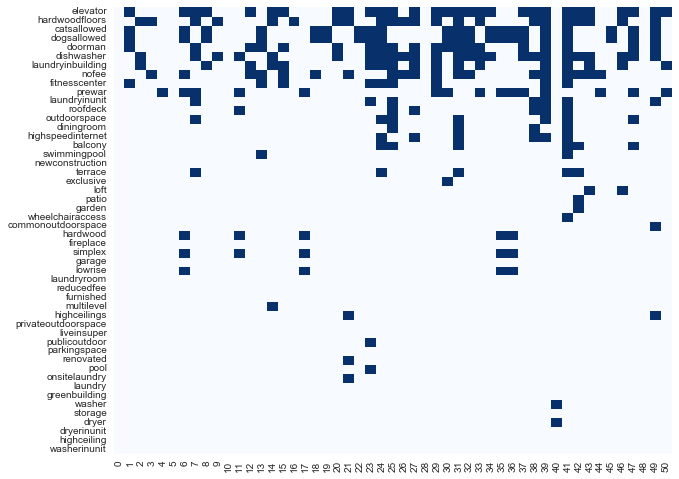

In [245]:
plt.figure(figsize=(10, 8))
sns.heatmap(feature_count_vec_df.loc[:50, freq_feature_words.index].T, cmap='Blues', cbar=False)

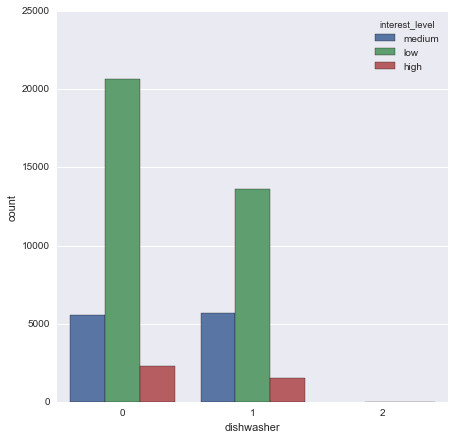

In [262]:
plt.figure(figsize=(7, 7))
sns.countplot(feature_count_vec_df.dishwasher, hue=df.interest_level)